In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

Base = automap_base()

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

# reflect the tables
tables = Base.classes

In [15]:
# View all of the classes that automap found
tables.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = tables.measurement
Station = tables.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a69c7584d0>,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

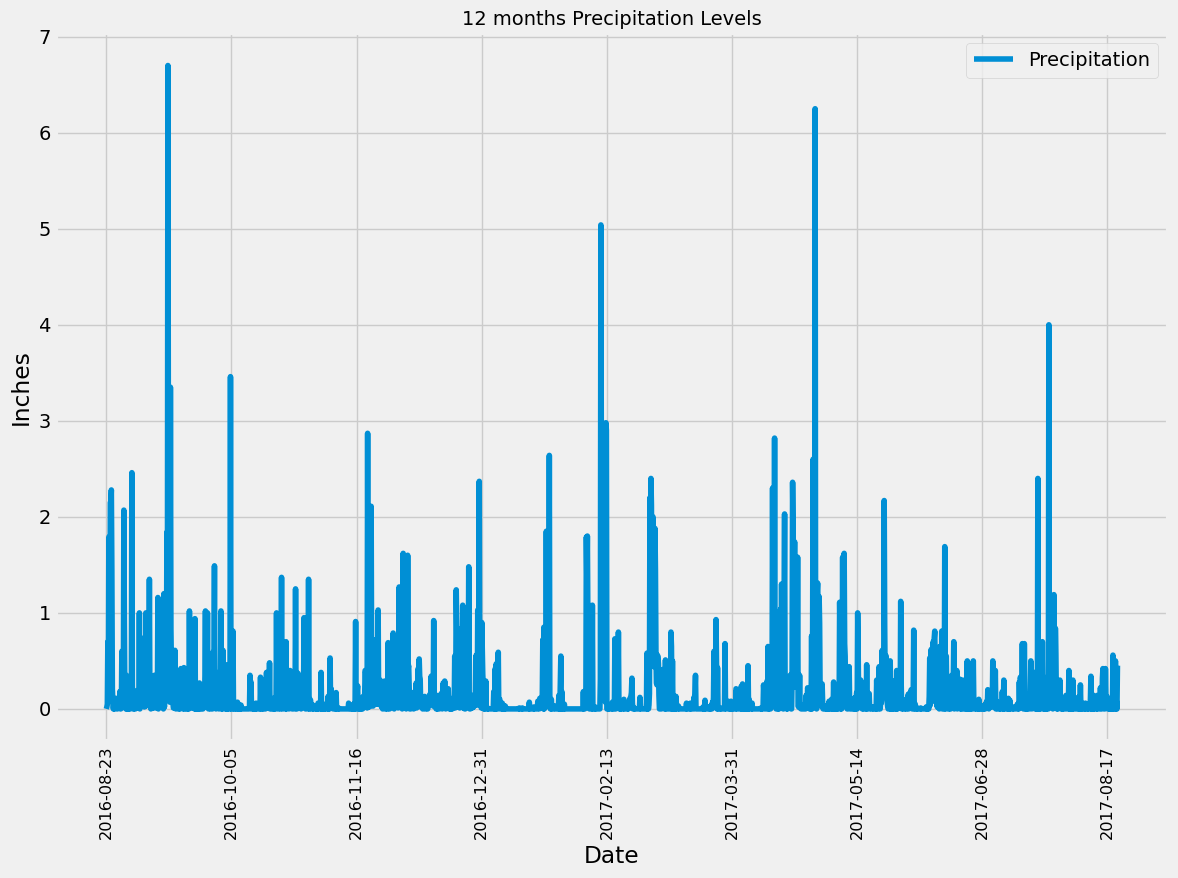

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent
# Calculate the date one year from the last date in data set.
prev_year = dt.date.fromisoformat(most_recent[0]) - dt.timedelta(days=365)
prev_year

# Perform a query to retrieve the data and precipitation scores
annual_prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= dt.date(2016,8,23)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
annual_prcp_df = pd.DataFrame(annual_prcp, columns=['Date','Precipitation']).set_index("Date").dropna(how="any")

# Sort the dataframe by date
annual_prcp_df = annual_prcp_df.sort_values("Date")
annual_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
annual_prcp_df.plot(ylabel="Inches", grid=True, figsize=(12,9))
plt.xticks(rotation=90, size="small")
plt.legend(loc="best")
plt.title("12 months Precipitation Levels", size=14)
plt.tight_layout()
plt.savefig("Output_Files/prcp_chart.png")
plt.show()

In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
annual_prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Measurement.station).distinct().count()
print(stations)

9


In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == station_activity[0][0]).all()
print(station_temps)
print("")
print(f"Temperature's for the most active station: {station_activity[0][0]}")
print(f"Lowest temperature for most active station: {station_temps[0][0]}")
print(f"Highest temperature for most active station: {station_temps[0][1]}")
print(f"Average temperature for most active station: {round(station_temps[0][2],2)}")

[(54.0, 85.0, 71.66378066378067)]

Temperature's for the most active station: USC00519281
Lowest temperature for most active station: 54.0
Highest temperature for most active station: 85.0
Average temperature for most active station: 71.66


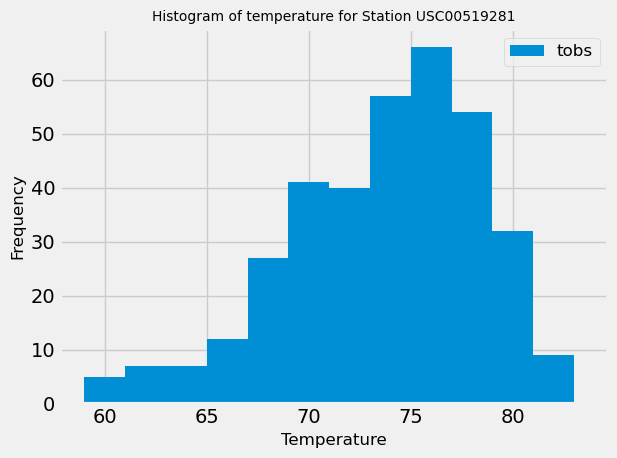

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_hist = session.query(Measurement.tobs).filter(Measurement.station == station_activity[0][0]).filter(Measurement.date >= dt.date(2016,8,18)).all()

active_hist_df = pd.DataFrame(active_hist, columns=["tobs"])

active_hist_df.plot(kind="hist", bins=12, label="tobs")
plt.legend(loc="best",prop={"size":12})
plt.xlim(min(active_hist_df["tobs"])*0.98,max(active_hist_df["tobs"])*1.02)
plt.xlabel("Temperature",size=12)
plt.ylabel("Frequency", size=12)
plt.title(f"Histogram of temperature for Station {station_activity[0][0]}",size=10)
plt.tight_layout()
plt.savefig("Output_Files/temp_hist.png")
plt.show()

# Close Session

In [39]:
# Close Session
session.close()